In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [34]:
df = pd.read_csv('trustpilot_reviews.csv')
df['date_experience'] = pd.to_datetime(df['date_experience'])
df['year'] = pd.to_datetime(df['date_experience']).dt.year
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

df.head()

,review_title,cust_name,cust_location,cust_reviews,cust_rating,cust_review_text,seller_response,date_experience,company,year
0,PERFECTION,Ellen Feibel,US,3,5,First: you had the books I wanted for a gift t...,False,2024-12-14,bookshop.org,2024
1,Good book buying experience,Randy,US,2,5,Great communication about my order. Books arri...,False,2024-12-14,bookshop.org,2024
2,I appreciate the selection and the…,Nana,US,3,5,I appreciate the selection and the prices of t...,False,2024-12-13,bookshop.org,2024
3,The books arrived in a very timely…,customer,US,1,5,The books arrived in a very timely fashion and...,False,2024-12-14,bookshop.org,2024
4,"Quick delivery, fab products",customer,GB,8,5,Beautiful books delivered extremely quickly co...,False,2024-12-16,bookshop.org,2024


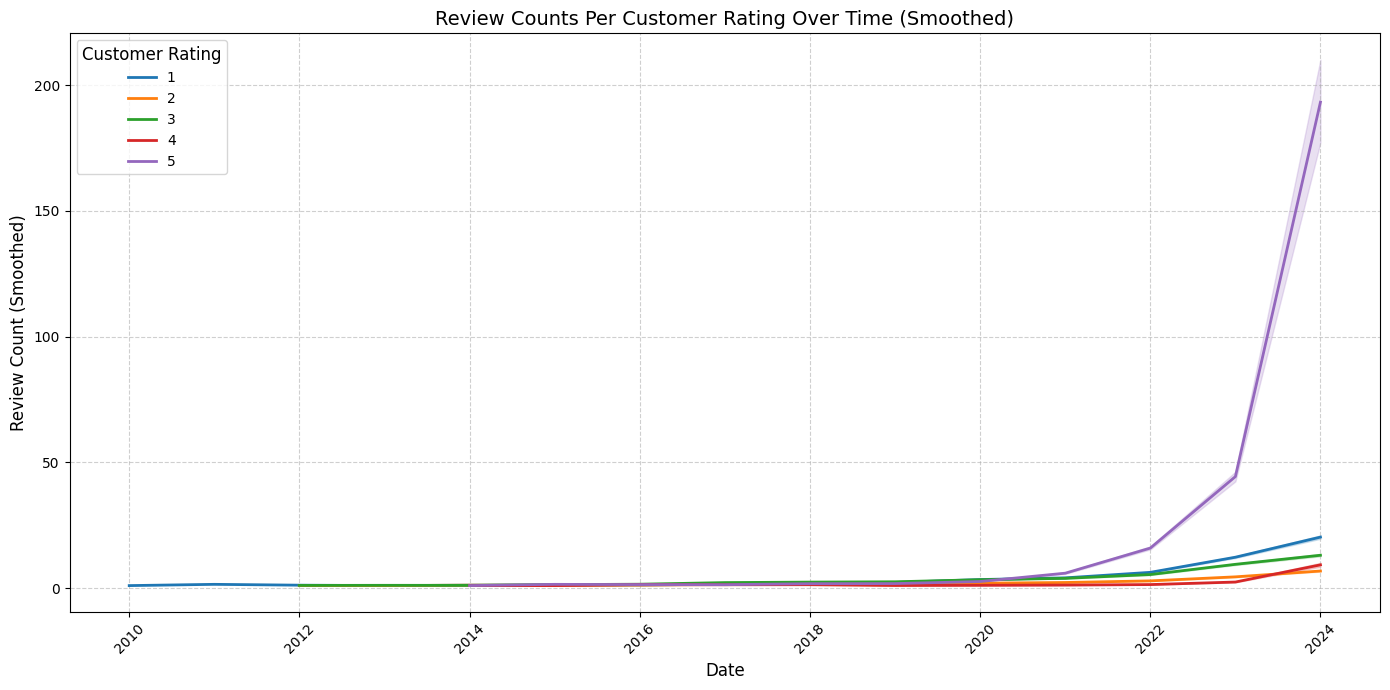

In [ ]:
review_counts = df.groupby(['date_experience', 'cust_rating']).size().reset_index(name='review_count')
review_counts['date_experience'] = review_counts['date_experience'].dt.to_period('Y').dt.to_timestamp()
review_counts['review_count_smoothed'] = review_counts.groupby('cust_rating')['review_count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count_smoothed',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count (Smoothed)', fontsize=12)
plt.title('Review Counts Per Customer Rating Over Time (Smoothed)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

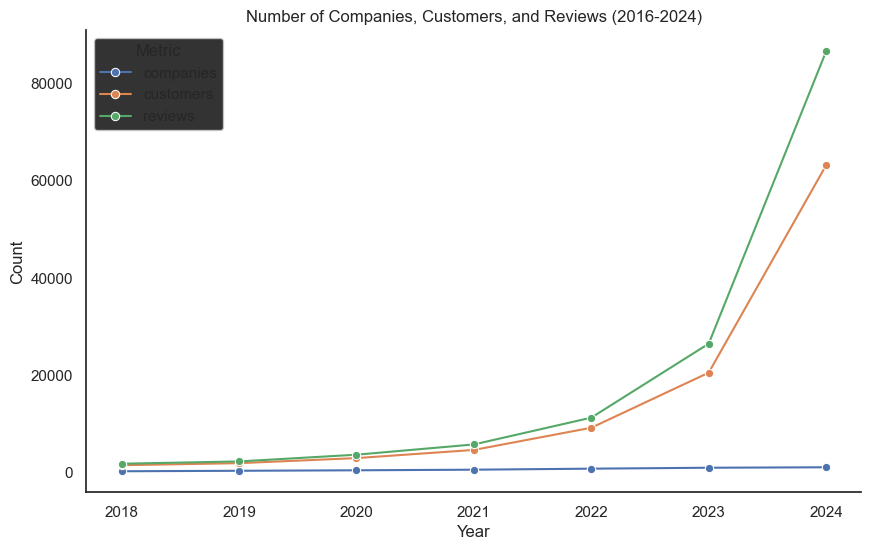

In [69]:

filtered_df = df[(df['year'] >= 2018) & (df['year'] <= 2024)]


summary_df = filtered_df.groupby('year').agg(
    companies=('company', 'nunique'),
    customers=('cust_name', 'nunique'),
    reviews=('cust_review_text', 'count')
).reset_index()


melted_df = summary_df.melt(id_vars='year', var_name='metric', value_name='count')


plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='year', y='count', hue='metric', marker='o')
sns.despine()
plt.title('Number of Companies, Customers, and Reviews (2016-2024)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Metric')
plt.show()

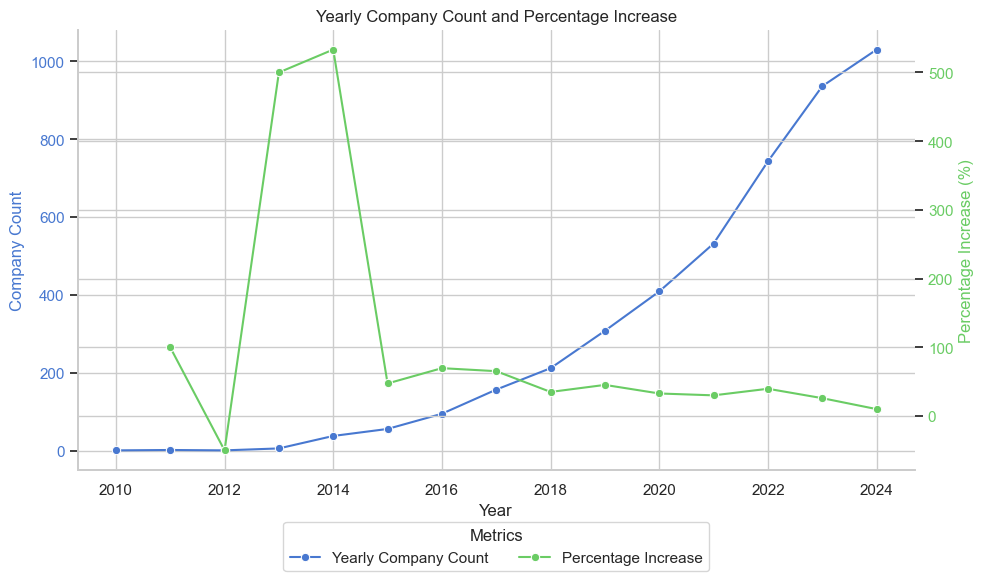

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
sns.lineplot(data=summary_df, x='year', y='companies', marker='o', ax=ax1, color='b')
sns.lineplot(data=summary_df, x='year', y='percentage_increase', marker='o', ax=ax2, color='g')

ax1.set_xlabel('Year')
ax1.set_ylabel('Company Count', color='b')
ax2.set_ylabel('Percentage Increase (%)', color='g')

ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='g')

lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
labels = ['Yearly Company Count', 'Percentage Increase']

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, title='Metrics')
sns.despine()
plt.title('Yearly Company Count and Percentage Increase')
plt.tight_layout()
plt.show()


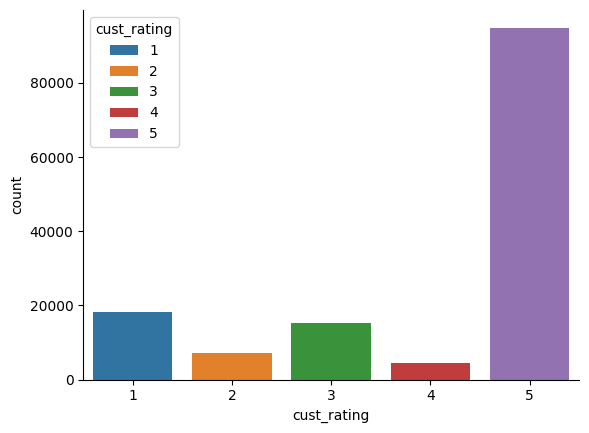

In [16]:
sns.countplot(x='cust_rating', data=df, hue='cust_rating', palette='tab10')
sns.despine()
plt.show()

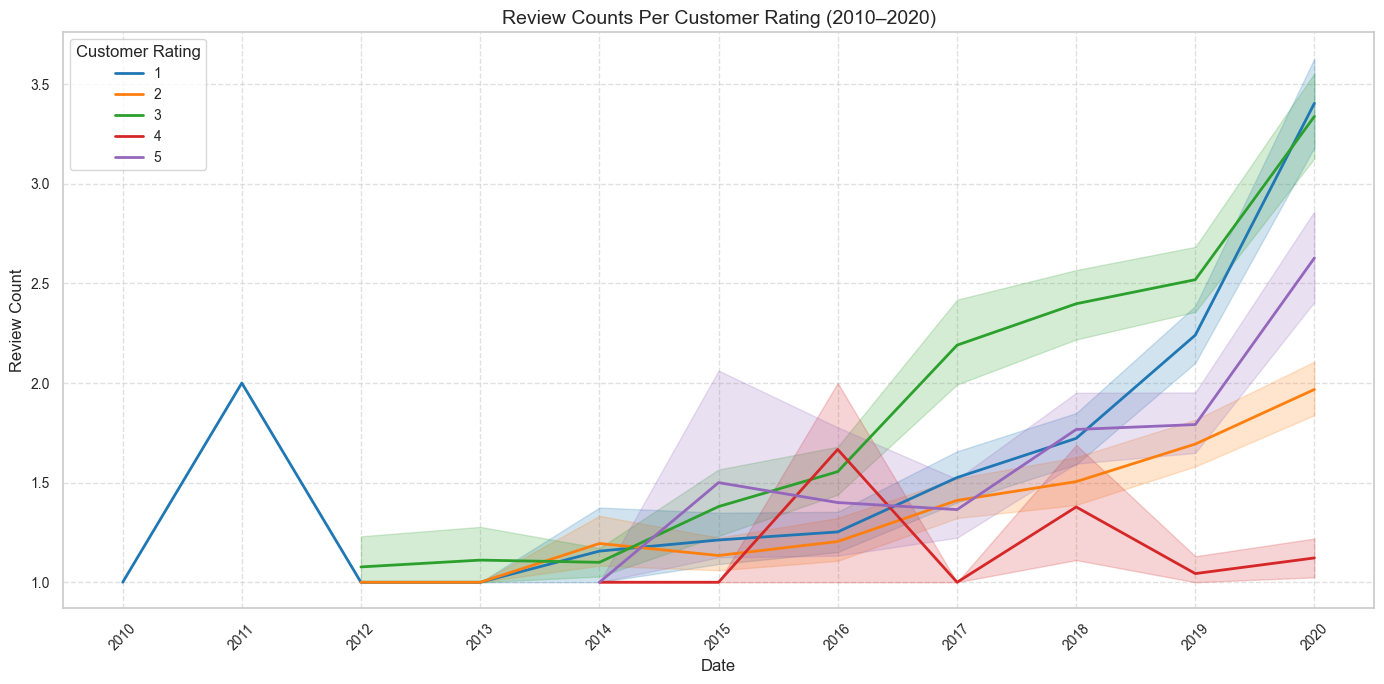

In [19]:
review_counts = review_counts[
    (review_counts['date_experience'] >= '2010-01-01') & (review_counts['date_experience'] <= '2020-12-31')
]


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    palette='tab10',
    linewidth=2
)


plt.grid(True, linestyle='--', alpha=0.6)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Counts Per Customer Rating (2010–2020)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

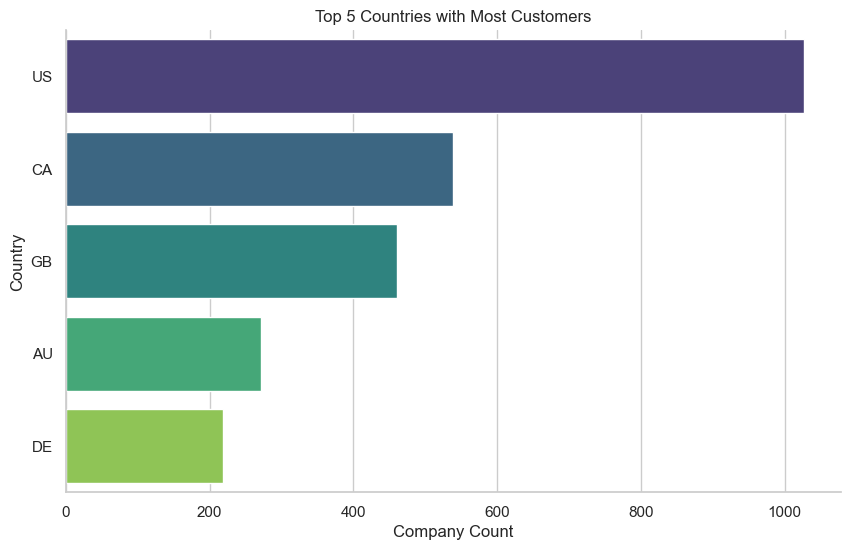

In [54]:
top_countries_customers = df.groupby('cust_location')['company'].nunique().nlargest(5).reset_index()
top_countries_customers.columns = ['country', 'company_count']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_countries_customers, 
    x='company_count', 
    y='country', 
    hue='country', 
    palette='viridis', 
    dodge=False, 
    legend=False
)
sns.despine()
plt.title('Top 5 Countries with Most Customers')
plt.xlabel('Company Count')
plt.ylabel('Country')
plt.show()


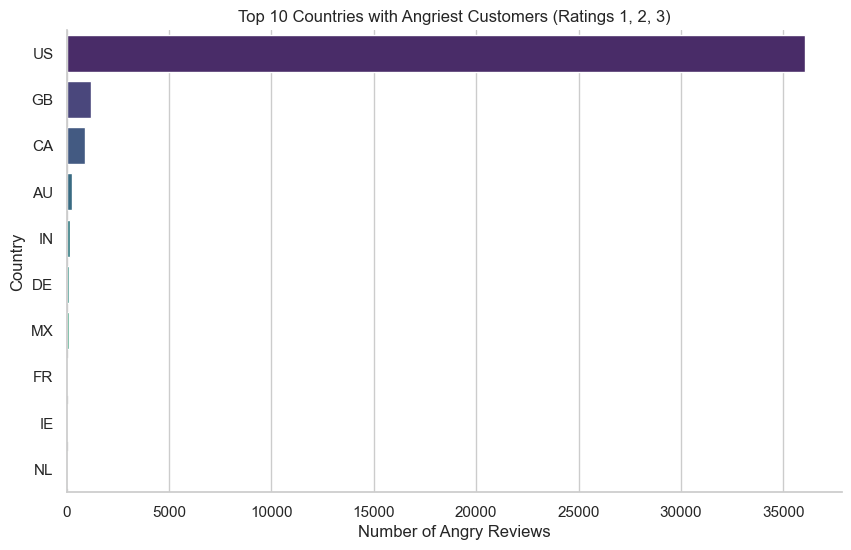

In [53]:
angriest_customers = df[df['cust_rating'].isin([1, 2, 3])].groupby('cust_location').size().nlargest(10).reset_index()
angriest_customers.columns = ['country', 'angry_reviews']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=angriest_customers, 
    x='angry_reviews', 
    y='country', 
    hue='country', 
    palette='viridis', 
    dodge=False, 
    legend=False
)
sns.despine()
plt.title('Top 10 Countries with Angriest Customers (Ratings 1, 2, 3)')
plt.xlabel('Number of Angry Reviews')
plt.ylabel('Country')
plt.show()


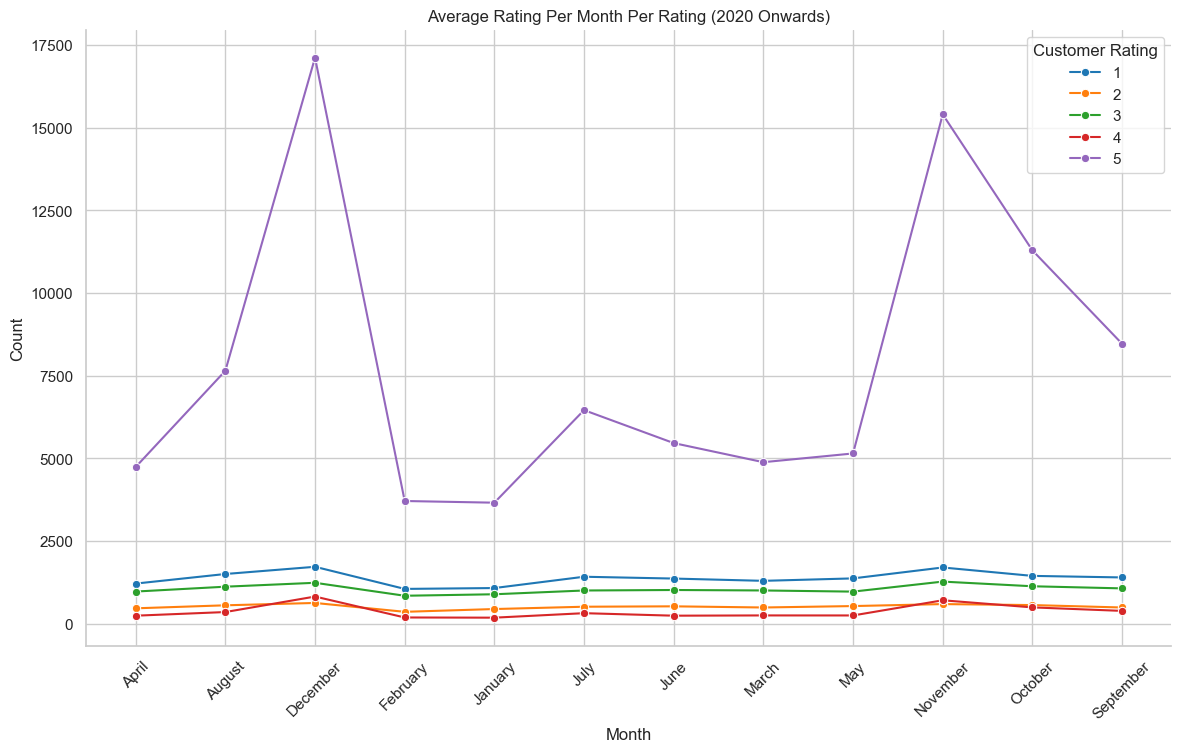

In [59]:
df['month'] = df['date_experience'].dt.month_name()
filtered_df = df[df['date_experience'] >= '2020-01-01']

average_rating_per_month_per_rating = filtered_df.groupby(['month', 'cust_rating']).size().reset_index(name='count')

plt.figure(figsize=(14, 8))
sns.lineplot(data=average_rating_per_month_per_rating, x='month', y='count', hue='cust_rating', marker='o', palette='tab10')
sns.despine()
plt.title('Average Rating Per Month Per Rating (2020 Onwards)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Customer Rating')
plt.xticks(rotation=45)
plt.show()


In [60]:
df.columns

Index(['review_title', 'cust_name', 'cust_location', 'cust_reviews',
       'cust_rating', 'cust_review_text', 'seller_response', 'date_experience',
       'company', 'year', 'year_month', 'month'],
      dtype='object')

In [61]:
df['review_length'] = df['cust_review_text'].str.len()
average_review_length = df.groupby('cust_rating')['review_length'].mean()


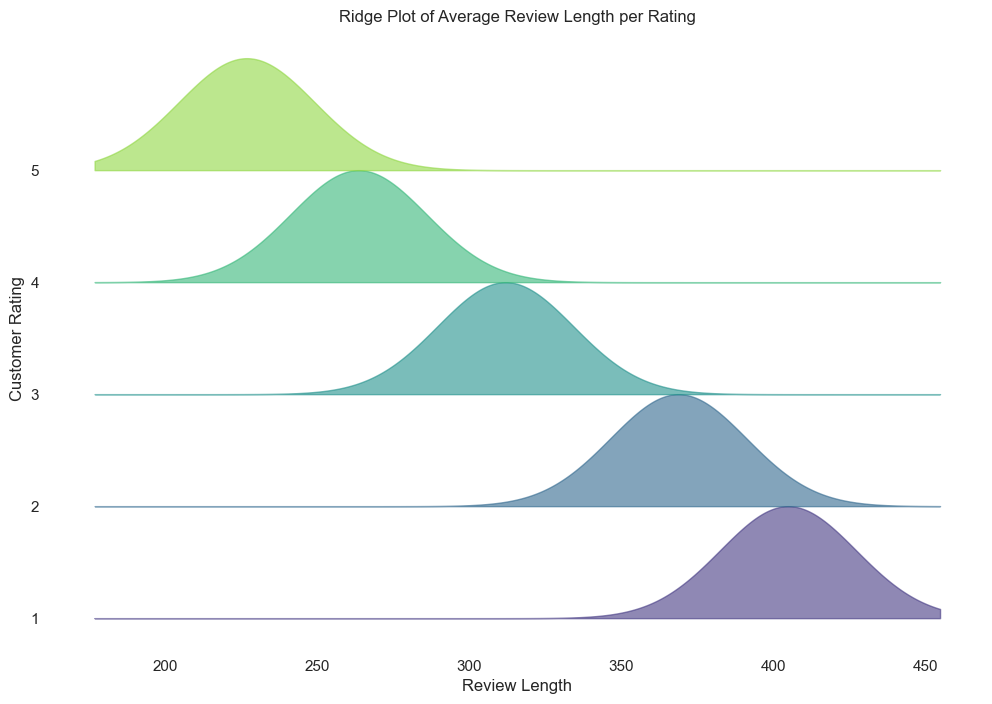

In [70]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df['review_length'] = df['cust_review_text'].str.len()
average_review_length = df.groupby('cust_rating')['review_length'].mean().reset_index()

x_range = np.linspace(
    average_review_length['review_length'].min() - 50, 
    average_review_length['review_length'].max() + 50, 
    500
)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(average_review_length))

for i, (index, row) in enumerate(average_review_length.iterrows()):
    y = np.exp(-(x_range - row['review_length']) ** 2 / (2 * 500))
    plt.fill_between(x_range, y + i, i, color=palette[i], alpha=0.6)

plt.yticks(
    ticks=np.arange(len(average_review_length)),
    labels=average_review_length['cust_rating'].astype(int)
)
plt.title("Ridge Plot of Average Review Length per Rating")
plt.xlabel("Review Length")
plt.ylabel("Customer Rating")
sns.despine(left=True, bottom=True)

plt.show()